In [101]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import requests
import zipfile
import re
import os
import pickle as pk

from io import BytesIO, StringIO
from os.path import join as pj
from pathlib import Path
import matplotlib as mpl
from matplotlib.colors import ListedColormap

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility


# read in data

In [102]:
airbnb_origin2022 = pd.read_csv('listings.csv')
#airbnb_origin2022.info() #check data type, the first three columns are redundant information.

# clean names

In [71]:
# This function will clean up column names in a data frame
# credit by https://gist.github.com/burkesquires/75aeebf4554e9fa427d14354d7fe048c
def clean_dataframe_column_names(df):
    cols = df.columns
    new_column_names = []

    for col in cols:
        new_col = col.lstrip().rstrip().lower().replace (" ", "_") #strip beginning spaces, makes lowercase, add underscore
        new_column_names.append(new_col)

    df.columns = new_column_names

In [72]:
clean_dataframe_column_names(airbnb_origin2022)

In [75]:
airbnb2022 = airbnb_origin2022[['id','host_id','host_listings_count','latitude','longitude','room_type','availability_365','neighbourhood_cleansed','price']
         ]
#rename the columns (orginal is too complex)
cols = airbnb2022.columns.values
airbnb2022.columns = cols

In [76]:
airbnb2022
airbnb2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69351 entries, 0 to 69350
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      69351 non-null  int64  
 1   host_id                 69351 non-null  int64  
 2   host_listings_count     69346 non-null  float64
 3   latitude                69351 non-null  float64
 4   longitude               69351 non-null  float64
 5   room_type               69351 non-null  object 
 6   availability_365        69351 non-null  int64  
 7   neighbourhood_cleansed  69351 non-null  object 
 8   price                   69351 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 4.8+ MB


# select professional

In [96]:
airbnbprof2022 = airbnb2022[airbnb2022['host_listings_count']>1 ]
airbnbprof2022.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34680 entries, 0 to 69350
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      34680 non-null  int64  
 1   host_id                 34680 non-null  int64  
 2   host_listings_count     34680 non-null  float64
 3   latitude                34680 non-null  float64
 4   longitude               34680 non-null  float64
 5   room_type               34680 non-null  object 
 6   availability_365        34680 non-null  int64  
 7   neighbourhood_cleansed  34680 non-null  object 
 8   price                   34680 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 2.6+ MB


In [78]:
hostprof=airbnbprof2022.groupby(['host_id'])

In [79]:
hostprof.size()

host_id
4775          7
6774          4
10115         3
10657         2
11431         2
             ..
478119106     2
478119652     4
478388494     7
478521110    10
478532050     2
Length: 10563, dtype: int64

In [80]:
host=airbnb2022.groupby(['host_id'])
host.size()

host_id
4775         7
4879         1
5653         1
6774         4
9323         1
            ..
478781847    1
478786396    1
478789726    1
478807343    1
478853993    1
Length: 45229, dtype: int64

# aggregating Listings by ward

In [91]:
import shapefile

In [104]:
ward = gpd.read_file(os.path.join('ward.gpkg'), driver='GPKG')
ward

,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry
0,Chessington South,E05000405,755.173,0.000,E09000021,Kingston upon Thames,50840,"MULTIPOLYGON (((516401.600 160201.800, 516407...."
1,Tolworth and Hook Rise,E05000414,259.464,0.000,E09000021,Kingston upon Thames,117160,"MULTIPOLYGON (((517829.600 165447.100, 517837...."
2,Berrylands,E05000401,145.390,0.000,E09000021,Kingston upon Thames,50449,"MULTIPOLYGON (((518107.500 167303.400, 518114...."
3,Alexandra,E05000400,268.506,0.000,E09000021,Kingston upon Thames,50456,"MULTIPOLYGON (((520480.000 166909.800, 520490...."
4,Beverley,E05000402,187.821,0.000,E09000021,Kingston upon Thames,117161,"MULTIPOLYGON (((522071.000 168144.900, 522063...."
...,...,...,...,...,...,...,...,...
620,Whalebone,E05000042,155.399,0.000,E09000002,Barking and Dagenham,117022,"MULTIPOLYGON (((549410.700 187450.700, 549391...."
621,Eastbrook,E05000030,345.060,0.000,E09000002,Barking and Dagenham,50856,"MULTIPOLYGON (((549991.500 184928.500, 549988...."
622,Chadwell Heath,E05000029,338.422,0.000,E09000002,Barking and Dagenham,117014,"MULTIPOLYGON (((547715.200 187914.200, 547712...."
623,Parsloes,E05000037,124.384,0.000,E09000002,Barking and Dagenham,117017,"MULTIPOLYGON (((547381.600 185753.600, 547377...."


In [99]:
gdf = gpd.GeoDataFrame(airbnbprof2022, 
      geometry=gpd.points_from_xy(airbnbprof2022['longitude'], airbnbprof2022['latitude'], crs='epsg:4326'))
gdf = gdf.to_crs('epsg:27700')

<AxesSubplot:>

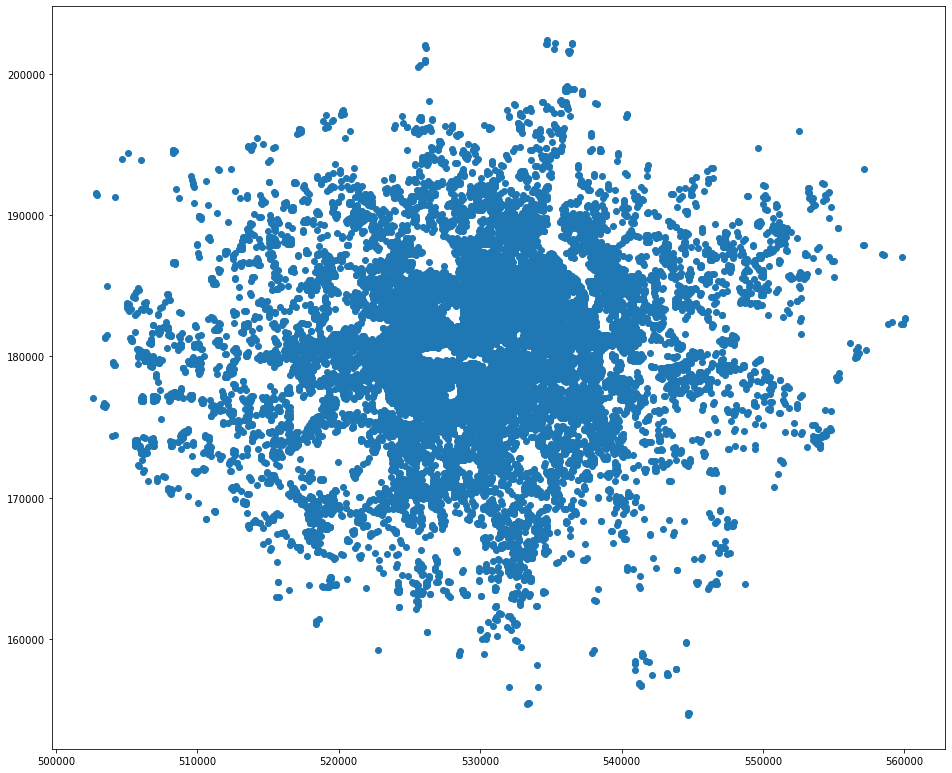

In [100]:
f,ax=plt.subplots(figsize=(16,16))
gdf.plot(ax=ax,  legend=True, legend_kwds={'loc':'upper right', 'title':'Recorded Crime Type'})

In [106]:
# wl == Ward Listings
wl = gpd.sjoin(gdf, ward[['GSS_CODE','geometry']], op='within').drop(columns=
    ['latitude','longitude','index_right','geometry']
)

wl

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_20171/3412994873.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: PROJCS["OSGB 1936 / British National Grid",GEOGCS[ ...

  wl = gpd.sjoin(gdf, ward[['GSS_CODE','geometry']], op='within').drop(columns=


,id,host_id,host_listings_count,room_type,availability_365,neighbourhood_cleansed,price,GSS_CODE
0,13913,54730,3.0,Private room,343,Islington,$50.00,E05000381
210,89870,54730,3.0,Entire home/apt,343,Islington,$145.00,E05000381
1239,1211331,6614363,3.0,Private room,314,Islington,$51.00,E05000381
1821,2173226,185201,4.0,Private room,0,Islington,$35.00,E05000381
1924,2053193,185201,4.0,Private room,0,Islington,$35.00,E05000381
...,...,...,...,...,...,...,...,...
56408,598124672880076606,28184118,3.0,Entire home/apt,68,Harrow,$500.00,E05000297
60921,651883271748870344,462140387,5.0,Private room,0,Harrow,$100.00,E05000297
58920,631026904518184628,156212093,2.0,Entire home/apt,73,Sutton,$150.00,E05000556
62799,665959349958547726,156212093,2.0,Private room,222,Sutton,$90.00,E05000556


In [107]:
wardprof=wl.groupby(['GSS_CODE'])

In [108]:
wardprof.size()

GSS_CODE
E05000026     17
E05000027     14
E05000028      9
E05000029      7
E05000030     13
            ... 
E05000646    128
E05000647    278
E05000648    110
E05000649    902
E09000001    321
Length: 621, dtype: int64